In [1]:
# Before starting import everything necessary
import numpy as np
import os
import simplejson as json
import sys
import torch
import yaml

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import Counter
from ssd.net import build_ssd

In [2]:
# Set presentation settings
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

with open('../plots/palette.json') as json_file:
    color_palette = json.load(json_file)
plt.style.use('../plots/ssdjet.mplstyle')

In [3]:
# Load configuration
CONFIG_FILE = '../ssd-config.yml'
MODEL = '../models/PF-Jet-SSD-tp.pth'

config = yaml.safe_load(open(CONFIG_FILE))
ssd_settings = config['ssd_settings']
ssd_settings['n_classes'] += 1

In [4]:
# Initiate SSD and load weights
torch.set_default_tensor_type('torch.cuda.FloatTensor')
net = build_ssd(0, config['ssd_settings'], inference=True)
if net.load_weights(MODEL):
    net.eval();

In [5]:
# Loop through the layers and collect data
w_zero, w_all = 0, 0
filters3x3 = []

for i, module in enumerate(net.mobilenet):
    # Skip the first layer, pooling and activation
    if i == 0 or type(module) in [torch.nn.modules.AvgPool2d,
                                  torch.nn.modules.activation.PReLU]:
        continue

    # Add all 3x3 filters to the array
    for layer in module:
        if type(layer) == torch.nn.modules.conv.Conv2d:
            for kernel in layer.weight:
                if kernel.size() == torch.Size([1, 3, 3]):
                    for fltr in kernel:
                        w_all += 9
                        w_zero += 9 - torch.count_nonzero(fltr)
                        scale = torch.max(torch.max(fltr), torch.abs(torch.min(fltr)))
                        if scale != 0.:
                            fltr = fltr / scale
                        fltr = fltr.flatten() + 1
                        fltr = ''.join(['{:.0f}'.format(x) for x in fltr.tolist()])
                        filters3x3.append(fltr)

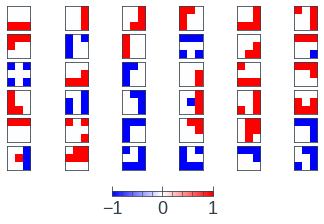

Network sparsity: 46.51%


In [6]:
# Show 
fig, axs = plt.subplots(nrows=6, ncols=6)

for f, ax in zip(Counter(filters3x3).most_common(36), axs.flat):
    f = [int(i)-1 for i in list(f[0])]
    f = np.array(f).reshape(3,3)
    
    pcm = ax.imshow(f, vmin=-1, vmax=1, cmap='bwr')
    ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    ax.grid(False)
    
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.tick_params(axis="both", which='both', top=False, bottom=False)

fig.colorbar(pcm, ax=axs, orientation="horizontal", pad=0.1, shrink=.3)

fig.savefig('../plots/filters')
plt.show()
print("Network sparsity: {:.2f}%".format(100 * w_zero / w_all))